# **Part 2: Genres and communities and plotting**

## 1) Write about genres and modularity.
**Answer:** 
Modularity evaluates how well a network is divided into communities by comparing how densely connected nodes are within the same group versus between different groups. In this case, genre labels extracted from the artists’ Wikipedia infoboxes are used to form the partitions. The modularity value lies between 0 and 1, where higher values indicate that the partition reflects a meaningful community structure, and lower values indicate a weak correspondence. A high modularity would therefore suggest that genre categories align closely with the underlying structure of the network, while a low modularity would suggest that genre is not a strong indicator of how the artists are actually organized within the network.

## 2) Detect the communities, discuss the value of modularity in comparison to the genres.

In [7]:
import pickle
import requests
import networkx as nx
import numpy as np
import pandas as pd
import re
import random
from collections import defaultdict
from networkx.algorithms.community import louvain_communities
from networkx.algorithms.community.quality import modularity
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm



# Download and load dataset
url = "https://raw.githubusercontent.com/Emmsiiii/Assignment-2---02805-Social-Graphs-and-Interactions/main/rock_performers_with_genres-2.pkl"
filename = "rock_performers_with_genres-2.pkl"

response = requests.get(url)
with open(filename, "wb") as f:
    f.write(response.content)

with open(filename, "rb") as f:
    data = pickle.load(f)

# Clean genres 
for entry in data:
    raw = entry.get("genre", "")
    genres = re.split(r"[;,/\n]+|\s{2,}", raw.lower().strip())
    entry["genres"] = [g.strip() for g in genres if g.strip()]

# Build undirected graph ---
G = nx.Graph()
names = {d["page_name"] for d in data}
genre_map = {d["page_name"]: d["genres"] for d in data}

for entry in data:
    src = entry["page_name"]
    content = entry["content"].lower()
    G.add_node(src, genres=genre_map.get(src, []))
    for tgt in names:
        if src != tgt and tgt.lower() in content:
            G.add_edge(src, tgt)

# Largest connected component ---
G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

#Filter nodes with genres 
G_genre = G.subgraph([n for n in G.nodes if G.nodes[n].get("genres")]).copy()

# Helper for modularity 
def compute_modularity(graph, partition_dict):
    communities = list(partition_dict.values())
    L = graph.number_of_edges()
    Q = 0
    for community in communities:
        subG = graph.subgraph(community)
        Lc = subG.number_of_edges()
        kc = sum(dict(graph.degree(community)).values())
        Q += Lc / L - (kc / (2 * L))**2
    return Q

# Modularity by first genre
partition_first = defaultdict(set)
for node in G_genre.nodes:
    first = G_genre.nodes[node]["genres"][0]
    partition_first[first].add(node)

mod_first = compute_modularity(G_genre, partition_first)

# Modularity by first non-rock genre 
partition_non_rock = defaultdict(set)
for node in G_genre.nodes:
    non_rock = next((g for g in G_genre.nodes[node]["genres"] if g != "rock"), G_genre.nodes[node]["genres"][0])
    partition_non_rock[non_rock].add(node)

mod_non_rock = compute_modularity(G_genre, partition_non_rock)

# Modularity by random genre 
partition_random = defaultdict(set)
for node in G_genre.nodes:
    rnd = random.choice(G_genre.nodes[node]["genres"])
    partition_random[rnd].add(node)

mod_random = compute_modularity(G_genre, partition_random)

# Modularity by alphabetical genre 
partition_alpha = defaultdict(set)
for node in G_genre.nodes:
    sorted_genres = sorted(G_genre.nodes[node]["genres"])
    if sorted_genres:
        alpha = sorted_genres[0]
        partition_alpha[alpha].add(node)

mod_alpha = compute_modularity(G_genre, partition_alpha)

# Louvain communities 
communities_louvain = louvain_communities(G_genre, seed=42)
mod_louvain = modularity(G_genre, communities_louvain)

# Output results 
print(f"Modularity (First genre):       {mod_first:.4f}")
print(f"Modularity (Non-rock genre):    {mod_non_rock:.4f}")
print(f"Modularity (Random genre):      {mod_random:.4f}")
print(f"Modularity (Alphabetical genre):{mod_alpha:.4f}")
print(f"Modularity (Louvain):           {mod_louvain:.4f}")
print(f"Number of Louvain communities:  {len(communities_louvain)}")


Modularity (First genre):       0.0484
Modularity (Non-rock genre):    0.0438
Modularity (Random genre):      0.0142
Modularity (Alphabetical genre):0.0963
Modularity (Louvain):           0.3274
Number of Louvain communities:  7


**Answer:**  The modularity values show a clear distinction between data-driven community detection (Louvain) and genre-based partitions. The Louvain algorithm produ a modularity of 0.3401, which is substantially higher than any of the genre-based partitionings. This suggests that the communities detected by the network structure better capture the actual grouping of artists than genre labels do.
Among the genre-based approaches, using the alphabetically first genre performs best with a modularity of 0.0963, while the first listed genre and first non-rock genre produce a lower modularities around 0.0484 and 0.0438. The random genre baseline performs worst, with a modularity of only 0.0139, serving as a useful control.
These results indicate that while genre does contain some information about how artists are grouped, it is a weak signal in comparison to the patterns found directly in the network. Genre labels may be noisy, overlapping, or inconsistent across artists. Moreover, artists are often associated with multiple genres, which complicates any partitioning based solely on genre metadata.
In contrast, the Louvain method identifies 7 communities based entirely on the structure of connections between artists. The relatively high modularity score suggests that these structural communities are well-defined and capture real clustering behavior in the network, reflecting shared influences, collaborations, or cultural proximity beyond genre labels.

## 3) Calculate the matrix D and discuss your findings.

D: Confusion Matrix (Genres vs Louvain Communities):
                    0   1   2   3  4   5   6
alternative rock   29   7  33   4  4  20  13
hard rock          27   4   8  28  5   2  25
pop rock            8   7  18   9  1  16   5
alternative metal  27   1   0   1  3   1  22
rock                3  17  10  10  0   1   1
heavy metal         2   1   1  12  4   1  18
post-grunge        20   2   3   2  2   1   8


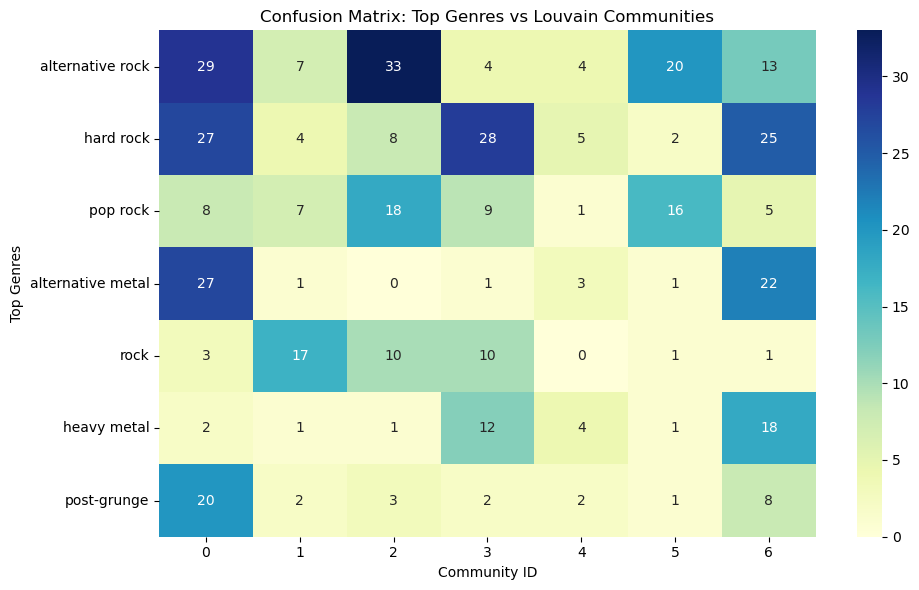

In [8]:
# Initialize confusion matrix D
conf_matrix = pd.DataFrame(0, index=top_genres, columns=range(len(communities_louvain)))

# Fill the matrix
for node in G_genre.nodes:
    comm = node_to_community[node]
    for genre in genres_dict[node]:
        if genre in top_genres:
            conf_matrix.loc[genre, comm] += 1

# Display matrix
print("D: Confusion Matrix (Genres vs Louvain Communities):")
print(conf_matrix)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix: Top Genres vs Louvain Communities")
plt.xlabel("Community ID")
plt.ylabel("Top Genres")
plt.tight_layout()
plt.show()


**Answer:** The confusion matrix compares the top genres to the Louvain‑detected communities in the network. Each cell shows how many artists of a given genre fall into each community.
- Genres are spread across multiple communities.
No single genre is isolated to one community. For example, alternative rock appears in almost all communities, especially in communities 0, 2, and 5. This shows that genre alone does not define community membership.
- Some genres show partial alignment with community structure.
Hard rock is mostly found in communities 0, 3, and 6.
Heavy metal is concentrated in communities 3 and 6.
These patterns suggest some genres are more structurally coherent in the network than others.
- General labels like "rock" are widely scattered, which makes sense since broad genres include many different substyles and do not capture network structure well.
- The Louvain communities are based on actual connections between artists (such as mentions), rather than metadata. As a result, they capture patterns like collaborations, influence, or shared background—things that genres do not account for.
This is consistent with the earlier modularity results, where Louvain produced a much higher modularity score than genre-based partitions. This confirms that the network’s structure provides a better explanation for community formation than genre labels.


## 4) Plot the communities and comment on your results.

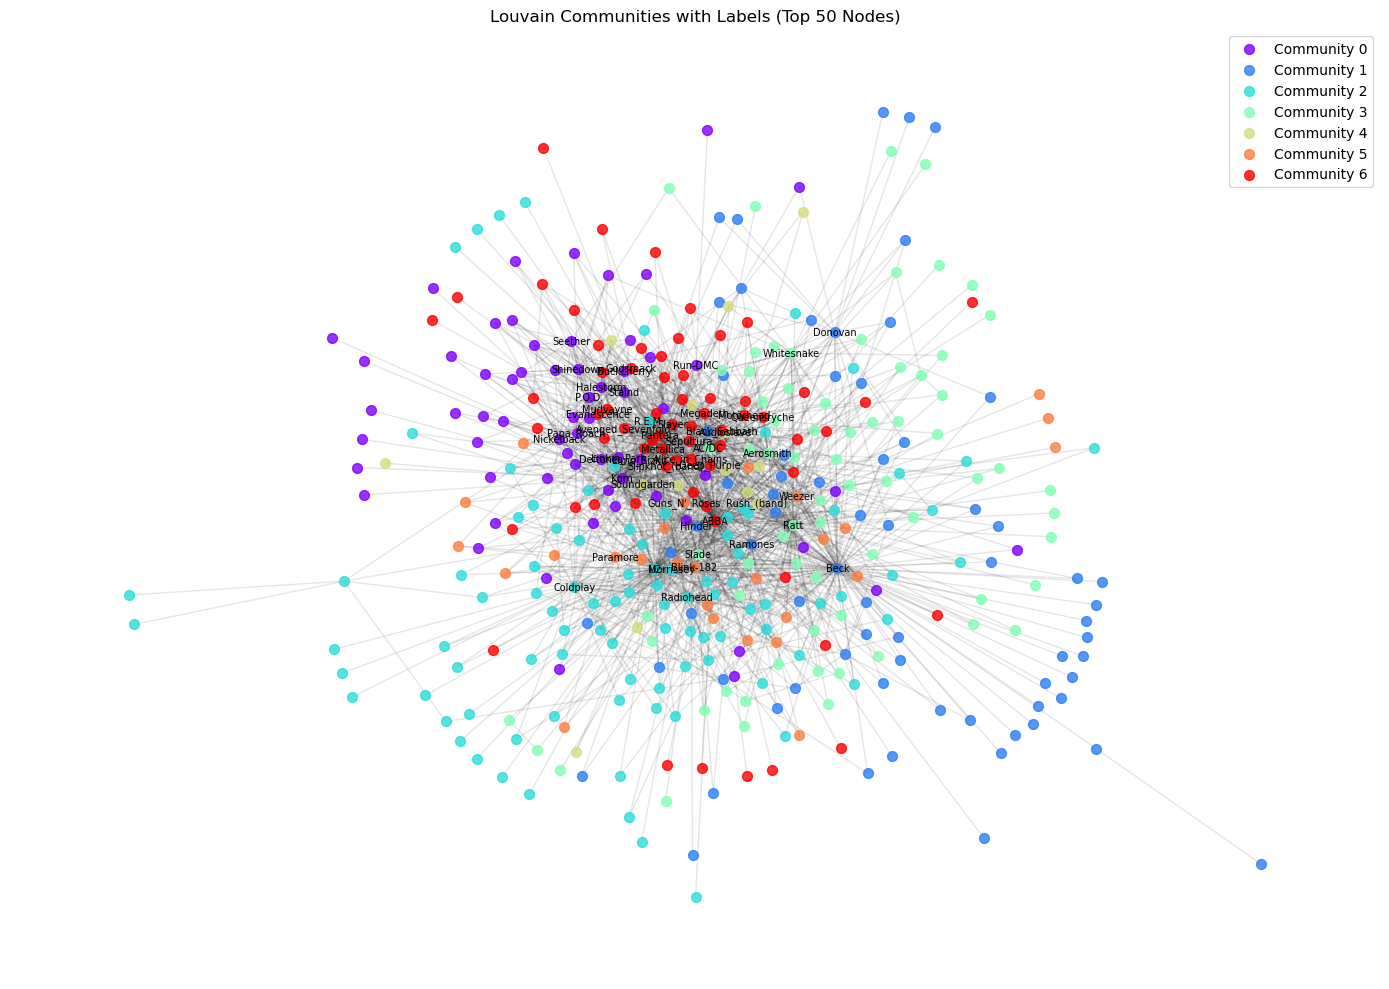

In [10]:
# Set community as node attribute
community_map = {}
for i, community in enumerate(communities_louvain):
    for node in community:
        community_map[node] = i
nx.set_node_attributes(G_genre, community_map, "community")

# Layout for consistent positioning
pos = nx.spring_layout(G_genre, seed=42)

# Color map
num_comms = len(communities_louvain)
colors = cm.rainbow(np.linspace(0, 1, num_comms))

# Plot
plt.figure(figsize=(14, 10))
for i, community in enumerate(communities_louvain):
    nx.draw_networkx_nodes(
        G_genre,
        pos,
        nodelist=community,
        node_color=[colors[i]],
        label=f"Community {i}",
        node_size=50,
        alpha=0.8
    )

# Draw edges
nx.draw_networkx_edges(G_genre, pos, alpha=0.1)

# Draw labels (optional: only for small subgraph or filtered nodes)
# Here: Only label top 50 high-degree nodes to avoid clutter
degrees = dict(G_genre.degree())
top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:50]
labels = {node: node for node in top_nodes}
nx.draw_networkx_labels(G_genre, pos, labels=labels, font_size=7, font_color="black")

plt.title("Louvain Communities with Labels (Top 50 Nodes)")
plt.axis("off")
plt.legend()
plt.tight_layout()
plt.show()


**Answer:** The plotted graph illustrates the Louvain-detected communities within the rock artist network. Each node represents an artist, and nodes are colored based on their assigned community. The 50 highest-degree nodes (most connected) are labeled to provide insight into prominent figures within each cluster.
The plot shows following:
- Clear clustering: Distinct color groupings confirm that the Louvain algorithm successfully partitions the graph into structurally meaningful communities. These clusters are tightly packed, indicating high intra-community connectivity.
- Community boundaries: While the core of the network appears densely connected, peripheral nodes tend to form more isolated clusters, often corresponding to niche subgenres or localized influences.
- Overlap and blending: Some communities are visually interwoven, suggesting that artists span multiple genres or share broad connections. This supports earlier findings that genres do not perfectly align with structural communities.
- Influential nodes: Many of the labeled nodes (for example, Radiohead, Coldplay, Run-DMC, Beck) are highly connected, likely acting as bridges between communities. Their presence near the center reinforces their importance in the global network structure.
- Community diversity: The fact that top-labeled artists appear in multiple communities reflects genre fluidity in the rock domain, with artists often associated with multiple styles over time.
Overall, the visual confirms that the Louvain algorithm captures meaningful structural patterns, though these do not always align with genre-based classifications, further emphasizing that real-world artist relationships are more complex than genre labels alone can express.

# Part 4: Sentiment of the artists and communities